In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from cmcrameri import cm
from pqcd.utils import (
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat,
    )

from plot_utils import rcparams
plt.rcParams.update(rcparams)

In [2]:
pqcd_region = pqcd.get_pqcd_region()

In [3]:
def plot_eos(set, variety, n, c, ax, mu_mark, label_mu=False):

    eos = pd.read_csv(f'../data/eos-draws-modified/tests/{set:02}/{variety}agn/eos-draw-{n:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

    chemical_potential = (energy_density+pressure)/number_density

    # Interpolate over chemical potential
    pressure_interp = np.interp(pqcd_region['mu_array'], chemical_potential, pressure)
    number_density_interp = np.interp(pqcd_region['mu_array'], chemical_potential, number_density)

    ax.plot(
        number_density/nsat,
        pressure,
        c='k',
        alpha=0.5,
    )
    ax.plot(
        number_density_interp/nsat,
        pressure_interp, 
        c=c
        )
    ax.plot(
        number_density_interp[0]/nsat,
        pressure_interp[0],
        marker='o',
        c=c,
        markersize=5,
    )
    ax.plot(
        number_density_interp[-1]/nsat,
        pressure_interp[-1],
        marker='o',
        c=c,
        markersize=5,
    )
    if label_mu:
        ax.text(
            number_density_interp[0]/nsat,
            pressure_interp[0]+0.05,
            '$\mu = 2.4\,\mathrm{GeV}$',
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=11,
            rotation=36,
            rotation_mode='anchor',
        )
        ax.text(
            number_density_interp[-1]/nsat,
            pressure_interp[-1]+0.05,
            '$\mu = 2.6\,\mathrm{GeV}$',
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=11,
            rotation=40,
            rotation_mode='anchor',
        )
    for mu in mu_mark:
        p_at_mu = pressure_interp[np.argmin(np.abs(pqcd_region['mu_array']-mu))]
        n_at_mu = number_density_interp[np.argmin(np.abs(pqcd_region['mu_array']-mu))]
        ax.plot(
            n_at_mu/nsat,
            p_at_mu,
            marker='o',
            c=c,
            markersize=3,
        )

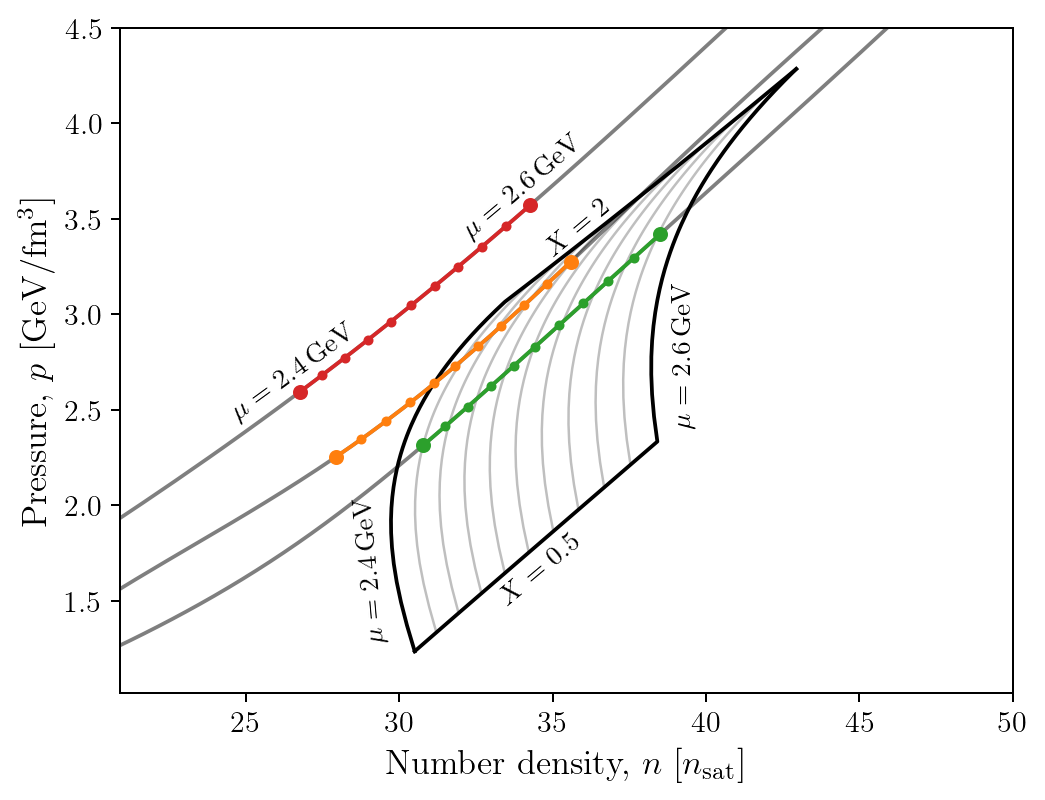

In [4]:
mu_mark = np.arange(2.42, 2.58, 0.02)

fig, ax = plt.subplots(dpi=180)

# pQCD region boundaries
# ----------------------

ax.plot(
    pqcd_region['left_n_boundary']/nsat, 
    pqcd_region['left_p_boundary'], 
    'k'
    )
ax.plot(
    pqcd_region['right_n_boundary']/nsat, 
    pqcd_region['right_p_boundary'], 
    'k'
    )

# Constant mu lines at each mu_mark
# ---------------------------------

for mu in mu_mark:

    p_boundary_array = np.zeros(len(pqcd_region['X_array']))
    n_boundary_array = np.zeros(len(pqcd_region['X_array']))

    for i, X in enumerate(pqcd_region['X_array']):
        pQCDX = pqcd.pQCD(X)
        p_boundary_array[i] = pQCDX.pH(mu)
        n_boundary_array[i] = pQCDX.nH(mu)

    ax.plot(
        n_boundary_array/nsat,
        p_boundary_array, 
        alpha=0.25, 
        c='k',
        zorder=0.1,
        linewidth=1
    )

# An EOS which doesn't overlap the region at all
# ----------------------------------------------

set = 0
variety = 'hyp'
n = 8

plot_eos(set, variety, n, 'C3', ax, mu_mark, label_mu=True)

# An EOS which overlaps the region but doesn't pass through it
# ------------------------------------------------------------

set = 0
variety = 'qrk'
n = 473

plot_eos(set, variety, n, 'C1', ax, mu_mark)

# An EOS which passes through the region
# --------------------------------------

set = 0
variety = 'qrk'
n = 184

plot_eos(set, variety, n, 'C2', ax, mu_mark)

# Labels
# ------

ax.text(33.5, 1.47, '$X = 0.5$', fontsize=11, rotation=40, rotation_mode='anchor')
ax.text(35, 3.3, '$X = 2$', fontsize=11, rotation=40, rotation_mode='anchor')

ax.text(29.5, 1.28, '$\mu = 2.4\,\mathrm{GeV}$', fontsize=11, rotation=95, rotation_mode='anchor')
ax.text(39.5, 2.4, '$\mu = 2.6\,\mathrm{GeV}$', fontsize=11, rotation=90, rotation_mode='anchor')

ax.set_xlim((20.899241856209166, 50))
ax.set_ylim((1.0183050679544774, 4.5))

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]');

In [5]:
from operator import sub

def get_aspect(ax):
    # Function used when converting line derivative to rotation angle for the 
    # text labels
    # https://stackoverflow.com/questions/41597177/get-aspect-ratio-of-axes
    
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

In [6]:
mu_low = 2.4
mu_high = 3
res = 100

mu_array = np.linspace(mu_low, mu_high, res)
pqcd_region = pqcd.get_pqcd_region(mu_high=mu_high)

In [7]:
p_boundary_arrays = []
n_boundary_arrays = []
mu_boundary_arrays = []

# Get the fixed-X arrays next
for X in [0.5, 2]:
    p_boundary_arrays.append(np.zeros(res))
    n_boundary_arrays.append(np.zeros(res))
    mu_boundary_arrays.append(np.zeros(res))
    for i, mu in enumerate(mu_array):
        pQCDX = pqcd.pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pH(mu)
        n_boundary_arrays[-1][i] = pQCDX.nH(mu)
        mu_boundary_arrays[-1][i] = mu

In [8]:
mu_mark = np.arange(mu_low, mu_high, 0.02)
mu_mark

array([2.4 , 2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.58, 2.6 ,
       2.62, 2.64, 2.66, 2.68, 2.7 , 2.72, 2.74, 2.76, 2.78, 2.8 , 2.82,
       2.84, 2.86, 2.88, 2.9 , 2.92, 2.94, 2.96, 2.98, 3.  ])

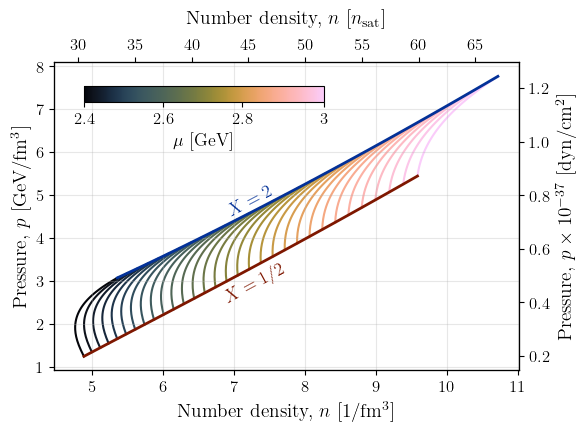

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

# pQCD region boundaries
# ----------------------

ax.plot(
    n_boundary_arrays[0], 
    p_boundary_arrays[0], 
    c=cm.roma(0.),
    lw=2
    )
ax.plot(
    n_boundary_arrays[1], 
    p_boundary_arrays[1], 
    c=cm.roma(1.),
    lw=2
    )

# Constant mu lines at each mu_mark
# ---------------------------------

cmap = cm.batlowK

for j, mu in enumerate(mu_mark):

    p_boundary_array = np.zeros(len(pqcd_region['X_array']))
    n_boundary_array = np.zeros(len(pqcd_region['X_array']))

    for i, X in enumerate(pqcd_region['X_array']):
        pQCDX = pqcd.pQCD(X)
        p_boundary_array[i] = pQCDX.pH(mu)
        n_boundary_array[i] = pQCDX.nH(mu)

    ax.plot(
        n_boundary_array,
        p_boundary_array, 
        c=cmap(j/(len(mu_mark)-1)),
        zorder=0.1,
    )

# Labels
# ------

aspect = get_aspect(ax)

x = 0.5*(n_boundary_arrays[0][0] + n_boundary_arrays[0][-1])
y = p_boundary_arrays[0][np.argmin(np.abs(n_boundary_arrays[0] - x))]
d = (p_boundary_arrays[0][-1] - p_boundary_arrays[0][0])/(n_boundary_arrays[0][-1] - n_boundary_arrays[0][0])
rot = (180/np.pi)*np.arctan(d*aspect)

ax.text(
    x, 
    y-0.2, 
    '$X = 1/2$', 
    fontsize=13, 
    ha='center',
    va='top',
    rotation=rot, 
    rotation_mode='anchor', 
    c=cm.roma(0.)
)

# x = 0.5*(n_boundary_arrays[1][0] + n_boundary_arrays[1][-1])
y = p_boundary_arrays[1][np.argmin(np.abs(n_boundary_arrays[1] - x))]
d = (p_boundary_arrays[1][-1] - p_boundary_arrays[1][0])/(n_boundary_arrays[1][-1] - n_boundary_arrays[1][0])
rot = (180/np.pi)*np.arctan(d*aspect)

ax.text(
    x, 
    y+0.28, 
    '$X = 2$', 
    fontsize=13, 
    ha='center',
    va='center',
    rotation=rot, 
    rotation_mode='anchor',
    c=cm.roma(1.)
)

# ---

cax = fig.add_axes([0.175, 0.78, 0.4, 0.04])
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    cax=cax, 
    ticks=[0, 0.33, 0.66, 1],
    orientation='horizontal',
    )
cbar.set_ticklabels(['2.4', '2.6', '2.8', '3'])
cbar.set_label('$\mu$ [GeV]', size=13)

# ---

twinx = ax.twinx()
twinx.set_ylim(1e-37*GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure, $p \times 10^{-37}\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twiny = ax.twiny()
twiny.set_xlim(np.array(ax.get_xlim())/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=10)

# ---

ax.set_xlabel('Number density, $n$ [1/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/paper/pqcd_window.pdf', bbox_inches='tight')

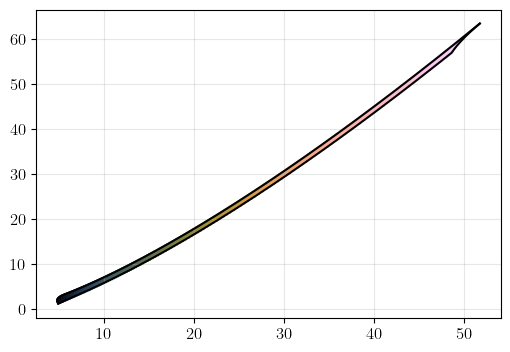

In [10]:
mu_low = 2.4
mu_high = 5
res = 100

mu_array = np.linspace(mu_low, mu_high, res)
pqcd_region = pqcd.get_pqcd_region(mu_high=mu_high)

mu_mark = np.arange(mu_low, mu_high, 0.02)

fig, ax = plt.subplots(figsize=(6,4))

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

# pQCD region boundaries
# ----------------------

ax.plot(
    pqcd_region['left_n_boundary'], 
    pqcd_region['left_p_boundary'], 
    'k'
    )
ax.plot(
    pqcd_region['right_n_boundary'], 
    pqcd_region['right_p_boundary'], 
    'k'
    )

# Constant mu lines at each mu_mark
# ---------------------------------

cmap = cm.batlowK

for j, mu in enumerate(mu_mark):

    p_boundary_array = np.zeros(len(pqcd_region['X_array']))
    n_boundary_array = np.zeros(len(pqcd_region['X_array']))

    for i, X in enumerate(pqcd_region['X_array']):
        pQCDX = pqcd.pQCD(X)
        p_boundary_array[i] = pQCDX.pH(mu)
        n_boundary_array[i] = pQCDX.nH(mu)

    ax.plot(
        n_boundary_array,
        p_boundary_array, 
        c=cmap(j/(len(mu_mark)-1)),
        zorder=0.1,
    )

In [11]:
mu_vals = np.linspace(2.4, 3, num=10000)
X_vals = np.linspace(0.5, 2, num=10000)

# Functions in the pQCD code assume X is fixed as a function of mu
X_list = np.linspace(0.5, 2, num=31)
X_list_highlight = [0.5, 1.0, 2.0]

p_dict = {X: [] for X in X_list}
n_dict = {X: [] for X in X_list}
cs2_dict = {X: [] for X in X_list}
epsilon_dict = {X: [] for X in X_list}

for X in X_list:
    pQCDX = pqcd.pQCD(X)
    for mu in mu_vals:
        p_dict[X].append(pQCDX.pH(mu))
        n_dict[X].append(pQCDX.nH(mu))
        cs2_dict[X].append(pQCDX.cs2H(mu))
        epsilon_dict[X].append(pQCDX.epsilonH(mu))

In [12]:
min_n = min([min(n_dict[0.5]), min(n_dict[2])])
max_n = max([max(n_dict[0.5]), max(n_dict[2])])

nstar_vals = np.linspace(min_n, max_n, num=25, endpoint=True)
nstar_vals

array([ 4.88079923,  5.12407022,  5.36734121,  5.6106122 ,  5.85388319,
        6.09715418,  6.34042517,  6.58369616,  6.82696715,  7.07023814,
        7.31350913,  7.55678012,  7.80005111,  8.0433221 ,  8.28659308,
        8.52986407,  8.77313506,  9.01640605,  9.25967704,  9.50294803,
        9.74621902,  9.98949001, 10.232761  , 10.47603199, 10.71930298])

In [13]:
mu_star_dict = {nstar: [] for nstar in nstar_vals}

for nstar in nstar_vals:
    for Xstar in X_vals:
        pQCDX = pqcd.pQCD(Xstar)
        n_vals = pQCDX.nH(mu_vals)
        mu_star_dict[nstar].append(mu_vals[np.argmin((n_vals - nstar)**2)])

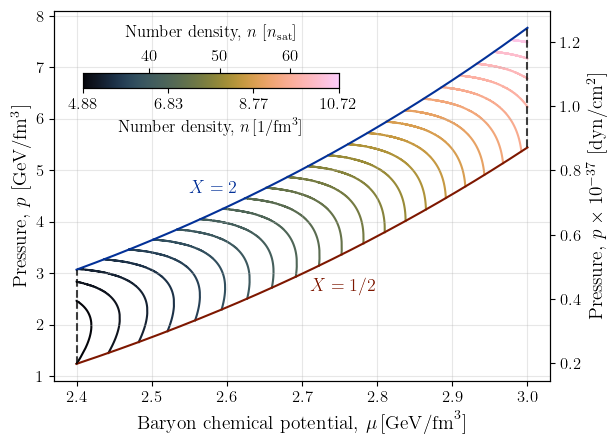

In [14]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

colors = [cm.roma(0.), cm.roma(1.)]
for i, X in enumerate([0.5, 2]):
    ax.plot(mu_vals, p_dict[X], c=colors[i])

ax.plot([2.4, 2.4], [p_dict[0.5][0], p_dict[2][0]], c='k', ls='--', alpha=0.75)
ax.plot([3, 3], [p_dict[0.5][-1], p_dict[2][-1]], c='k', ls='--', alpha=0.75)

# Constant n contours
# -------------------

cmap = cm.batlowK

for i, nstar in enumerate(nstar_vals):

    mu_star = np.array(mu_star_dict[nstar])

    pstar = []
    for X, mu in zip(X_vals, mu_star):
        pQCDX = pqcd.pQCD(X)
        pstar.append(pQCDX.pH(mu))
    pstar = np.array(pstar)

    mask = (mu_star > 2.4) & (mu_star < 3)

    ax.plot(
        mu_star[mask], 
        pstar[mask], 
        c=cmap(i/(len(nstar_vals)-1)), 
        zorder=0.1
    )

# Labels
# ------

ax.text(
    2.71,
    2.55, 
    '$X = 1/2$', 
    fontsize=13, 
    ha='left',
    va='bottom',
    c=cm.roma(0.)
)

ax.text(
    2.55, 
    4.65, 
    '$X = 2$', 
    fontsize=13, 
    ha='left',
    va='center',
    c=cm.roma(1.)
)

nticks = 4
tick_vals = np.linspace(min_n, max_n, num=nticks, endpoint=True)
tick_labels = [f'{tick:.2f}' for tick in tick_vals]

cax = fig.add_axes([0.17, 0.72, 0.4, 0.03])
# cax.set_xlim(nstar_vals[0], nstar_vals[-1])
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    cax=cax, 
    ticks=(tick_vals-tick_vals[0])/(tick_vals[-1]-tick_vals[0]),
    orientation='horizontal',
    )
cbar.set_ticklabels(tick_labels)
cbar.set_label('Number density, $n\,[1/\mathrm{fm}^3]$', size=12)

twiny = cax.twiny()
twiny.set_xlim(np.array([nstar_vals[0], nstar_vals[-1]])/nsat)
twiny.set_xlabel('Number density, $n$ [$n_\mathrm{sat}$]', labelpad=9, size=12)

twinx = ax.twinx()
twinx.set_ylim(1e-37*GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure, $p \times 10^{-37}\ [\mathrm{dyn}/\mathrm{cm}^2]$')

ax.set_xlabel('Baryon chemical potential, $\mu\,[\mathrm{GeV/fm}^3]$')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/paper/pqcd_window_p_mu.pdf', bbox_inches='tight')